# Preliminary Study

## global imports

In [78]:
import os
import pandas as pd
import re
import json
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from IPython.display import display
from scipy import stats  
from tqdm.notebook import tqdm

EO_DATE = '2025_01_20'


In [17]:
before = pd.read_csv('data/before.csv')
before['locality'] = before['location'].str.split(', ').str[0]
before['region'] = before['location'].str.split(', ').str[1]
before.drop(columns=['location'], inplace=True)
# display(before.head())

# print(before['description'].iloc[0])

after = pd.read_csv('data/after.csv', index_col=0)
# display(after.head())

In [18]:
if os.path.exists('data/merged.csv'):
    merged = pd.read_csv('data/merged.csv')
else:
    # merge datasets on common columns
    rename_map_before = {
        'title': 'job_title',
        'locality': 'company_address_locality',
        'region': 'company_address_region',
        'publishedAt': 'job_posted_date',
        'companyName': 'company_name',
        'description': 'job_description_text',
        'experienceLevel': 'seniority_level',
        'applicationsCount': 'num_applications',
        'contractType': 'contract_type',
        'workType': 'work_type'
    }

    before = before.rename(columns=rename_map_before)

    common_columns = [col for col in before.columns if col in after.columns]

    merged = pd.concat([before, after], ignore_index=True)
    display(merged.head())

    # save merged dataset
    merged.dropna(inplace=True, subset=['job_description_text', 'job_posted_date'], how='any')
    merged.to_csv('data/merged.csv', index=False)
display(merged.head())

,job_title,job_posted_date,company_name,job_description_text,num_applications,contract_type,seniority_level,work_type,sector,company_address_locality,company_address_region,company_website,company_description
0,AI/ML Engineer,2024-05-29,Wesper,THE OPPORTUNITY\n\nWesper is looking for a sma...,Over 200 applicants,Full-time,Mid-Senior level,Engineering and Information Technology,Internet Publishing,New York,NY,NaN,NaN
1,ML Engineer at 100% Remote,2024-06-01,ELITE MENTE LLC,"Hello ,\n\nHope you are doing well!\n\nPlease ...",Be among the first 25 applicants,Full-time,Entry level,Engineering and Information Technology,Staffing and Recruiting,San Jose,CA,NaN,NaN
2,Machine Learning Engineer (L4) - Infrastructur...,2024-05-19,Netflix,At Netflix our goal is to entertain the world....,Over 200 applicants,Full-time,Not Applicable,Engineering and Information Technology,"Entertainment Providers, Technology, Informati...",Los Gatos,CA,NaN,NaN
3,ML Engineer-AI/ML,2024-04-30,Zortech Solutions,"Role: ML Engineer-AI/ML\n\nLocation: Austin, T...",67 applicants,Full-time,Entry level,Engineering and Information Technology,Human Resources Services,Austin,TX,NaN,NaN
4,ML/ Machine Learning/ Data Scientist/ AI/ Arti...,2024-05-20,HatchPros,"T+S\n\nUSC/GC\n\nNeed VISA, DL and LinkedIn\n\...",145 applicants,Contract,Mid-Senior level,Engineering and Information Technology,IT Services and IT Consulting,Richardson,TX,NaN,NaN


In [19]:
# regularize job description text
def regularize_text(text):
    if pd.isna(text):
        return ''
    text = text.lower() # lowercase
    text = re.sub(r'[^a-z\d\s]', ' ', text) # remove non-alphanumeric, non-space characters
    # text = re.sub(r'\.(\s|$)', ' ', text) # replace ending periods with spaces
    text = re.sub(r'\s+', ' ', text)
    return text.strip()
merged['description_reg'] = merged['job_description_text'].apply(regularize_text)
print(merged['description_reg'].iloc[80])

about ascendion ascendion is a full service digital engineering solutions company we make and manage software platforms and products that power growth and deliver captivating experiences to consumers and employees our engineering cloud data experience design and talent solution capabilities accelerate transformation and impact for enterprise clients headquartered in new jersey our workforce of 6 000 ascenders delivers solutions from around the globe ascendion is built differently to engineer the next ascendion engineering to elevate life we have a culture built on opportunity inclusion and a spirit of partnership come change the world with us build the coolest tech for world s leading brands solve complex problems and learn new skill experience the power of transforming digital engineering for fortune 500 clients master your craft with leading training programs and hands on experience experience a community of change makers join a culture of high performing innovators with endless idea

## eda

In [20]:
# summary statistics
before_all = before.shape[0]
before_distinct = before.nunique()
before_missing = before.isnull().sum()
before_sum = pd.DataFrame({'total_rows': before_all, 'distinct_values': before_distinct, 'missing_values': before_missing})
display(before_sum)

after_all = after.shape[0]
after_distinct = after.nunique()
after_missing = after.isnull().sum().T
after_sum = pd.DataFrame({'total_rows': after_all, 'distinct_values': after_distinct, 'missing_values': after_missing})
display(after_sum)


,total_rows,distinct_values,missing_values
title,862,450,0
publishedAt,862,142,12
companyName,862,519,1
description,862,748,0
applicationsCount,862,145,0
contractType,862,5,0
experienceLevel,862,7,0
workType,862,55,0
sector,862,156,3
locality,862,159,0


,total_rows,distinct_values,missing_values
job_posted_date,997,116,0
company_address_locality,997,178,47
company_address_region,997,87,113
company_name,997,488,0
company_website,997,478,14
company_description,997,480,12
job_description_text,997,795,1
seniority_level,997,7,9
job_title,997,450,0


<Figure size 1200x600 with 0 Axes>

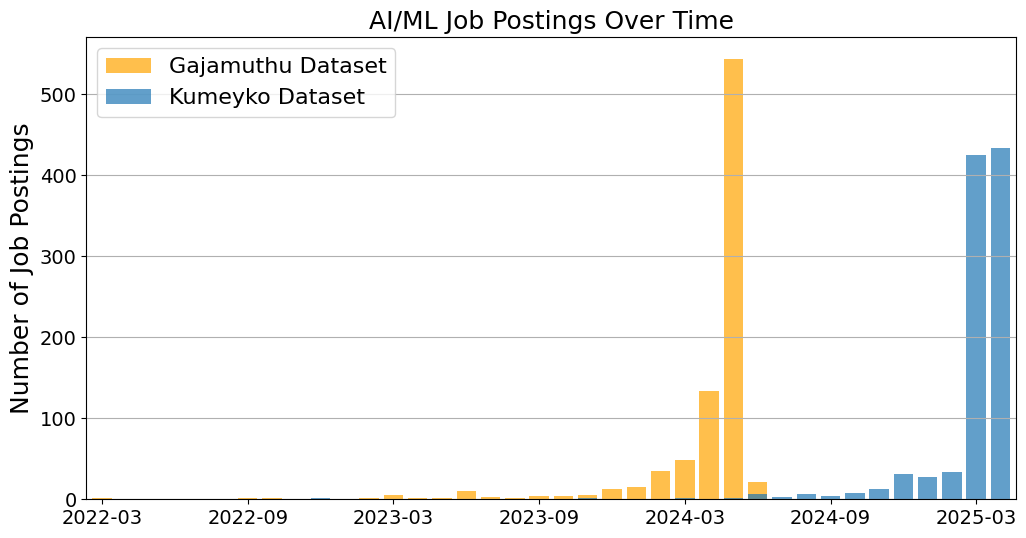

In [21]:
# total number of job postings over time, combining both datasets into one
plt.figure(figsize=(12, 6))
before['date'] = pd.to_datetime(before['publishedAt'])
after['date'] = pd.to_datetime(after['job_posted_date'])
merged['date'] = pd.to_datetime(merged['job_posted_date'])

before_counts = before['date'].dropna().dt.to_period('M').value_counts().sort_index()
after_counts = after['date'].dropna().dt.to_period('M').value_counts().sort_index()

min_date = min(before['date'].min(), after['date'].min())
max_date = max(before['date'].max(), after['date'].max())
# Generate ALL months in the range
all_months = pd.period_range(
    start=pd.Period(min_date, freq='M'),
    end=pd.Period(max_date, freq='M'),
    freq='M'
)

before_counts = before_counts.reindex(all_months, fill_value=0)
after_counts = after_counts.reindex(all_months, fill_value=0)

# combine the two series by date
# total_counts = before_counts.add(after_counts, fill_value=0)
# total_counts = total_counts.sort_index()
# plt.plot(total_counts.index, total_counts.values, marker='o', label='Total Job Postings')
# plt.bar(before_counts.index, before_counts.values, label='Gajamuthu Dataset')
# plt.bar(after_counts.index, after_counts.values, label='Kumeyko Dataset')
fig, ax = plt.subplots(figsize=(12, 6))
before_counts.plot(kind='bar', label='Gajamuthu Dataset', color='orange', alpha=0.7, ax=ax, width=0.8)
after_counts.plot(kind='bar', label='Kumeyko Dataset', alpha=0.7, ax=ax, width=0.8)
# set x axis range to be the union of both datasets
# ax.set_xlim(min(before_counts.index.min(), after_counts.index.min()), max(before_counts.index.max(), after_counts.index.max()))
plt.legend(fontsize=16)
plt.title('AI/ML Job Postings Over Time', fontsize=18)
# plt.xlabel('Date')
x_labels = all_months.astype(str)
ax.set_xticks(np.arange(len(x_labels), step=6)) 
ax.set_xticklabels(x_labels[::6], rotation=0, ha='center', fontsize=14)
plt.ylabel('Number of Job Postings', fontsize=18)
ax.tick_params(axis='y', labelsize=14)
plt.grid(axis='y')
plt.show()

## word processing

In [22]:
# put job descriptions into a single list for word processing
descriptions = merged['description_reg'].dropna().str.split().tolist()
print(f'Total number of job descriptions: {len(descriptions)}')
print(descriptions[0])

Total number of job descriptions: 1846
['the', 'opportunity', 'wesper', 'is', 'looking', 'for', 'a', 'smart', 'and', 'creative', 'engineer', 'to', 'lead', 'our', 'ai', 'ml', 'efforts', 'and', 'product', 'initiatives', 'this', 'includes', 'advanced', 'ml', 'modeling', 'for', 'large', 'scale', 'healthcare', 'data', 'synthesis', 'deep', 'physiological', 'signal', 'optimization', 'pipelines', 'and', 'generative', 'ai', 'architectures', 'the', 'right', 'candidate', 'will', 'have', 'an', 'opportunity', 'to', 'research', 'design', 'and', 'implement', 'novel', 'solutions', 'alongside', 'the', 'software', 'team', 'and', 'serve', 'as', 'a', 'subject', 'matter', 'expert', 'on', 'all', 'artificial', 'intelligence', 'matters', 'for', 'the', 'company', 'reports', 'into', 'vp', 'r', 'd', 'responsibilities', 'work', 'with', 'cto', 'vp', 'r', 'd', 'and', 'software', 'leadership', 'to', 'shape', 'and', 'commercialize', 'wesper', 's', 'ai', 'ml', 'strategy', 'design', 'and', 'implement', 'feature', 'engi

In [23]:
vocab = set([w for desc in descriptions for w in desc])
print(f'Total vocabulary size: {len(vocab)}')

Total vocabulary size: 21114


In [50]:
if os.path.exists("data/dei_terms.json"):
    with open('data/dei_terms.json', 'r') as f:
        dei = json.load(f)
        dei_narrow = dei['narrow']
        dei_expanded = dei['expanded']
    print(f"Loaded DEI terms from file. {len(dei_narrow)} narrow terms, {len(dei_expanded)} expanded terms.")

else:
    dei_narrow = ["dei", "diversity", "diverse", "equity", "equitable", "inclusion", "inclusive"]
    negative = ['finance', 'financial', 'fiscal', 'economic', 'expensive', 'expense', 'profit', 'pay', 'salary'] # exclude the other meaning of "equity"

    # get the 20 most similar words by word2vec for each of the DEI_NARROW terms
    from gensim.models import Word2Vec
    if not os.path.exists("word2vec.model"):
        model = Word2Vec(sentences=descriptions, vector_size=100, window=5, min_count=1, workers=4)
        model.save("word2vec.model")

    model = Word2Vec.load("word2vec.model")
    dei_expanded = set(dei_narrow)
    # similarities = {}
    for term in dei_narrow:
        if term in model.wv:
            # similarities[term] = {}
            similar_words = model.wv.most_similar(term, topn=50)
            for word, similarity in similar_words:
                if similarity < 0.6:
                    continue
                dei_expanded.add(word)
                    # similarities[term][word] = similarity
    for word in list(dei_expanded): # filter out financial words from expanded list
        for neg in negative: 
            if (word == neg) or (model.wv.similarity(word, neg) > 0.5):
                # print(f'Removed {word} due to similarity to negative term {neg}')
                dei_expanded.remove(word)
                break
    print(f"{len(dei_expanded)} Expanded DEI terms:", dei_expanded)
    dei_expanded = list(dei_expanded)
    dei = {'narrow': dei_narrow, 'expanded': dei_expanded}
    with open('data/dei_terms.json', 'w') as f:
        json.dump(dei, f, indent=4)

Loaded DEI terms from file. 7 narrow terms, 81 expanded terms.


In [51]:
print('"'+'", "'.join(sorted(dei_expanded))+'"')

"act", "actqualtrics", "adaptable", "aim", "altos", "amazing", "amazonians", "aspxcommitment", "atelio", "atmosphere", "backgrounds", "belonging", "belongs", "benefitscompetitive", "celebrate", "celebrates", "celebrating", "celonis", "collaborative", "commitment", "committed", "communicative", "communities", "competitive", "creating", "cultivating", "culture", "dedication", "dibe", "differences", "diverse", "diversity", "embrace", "embraces", "embracing", "empathetic", "employer", "empowering", "encourages", "entrepreneurial", "equal", "equality", "equitable", "ethical", "foster", "fostering", "free", "fun", "gives", "grant", "gritty", "happiness", "honesty", "inclusion", "inclusive", "inclusivity", "inspired", "intentionally", "packagecompetitive", "personify", "pluspaypal", "promote", "providing", "remarkable", "respect", "respectful", "retaining", "rewarding", "sales", "society", "spirit", "stayed", "strive", "stronger", "supportive", "values", "viewpoints", "voices", "welcoming", "

In [52]:
# get frequencey of DEI terms in job descriptions
for term in dei_expanded:
    merged[f'{term}_count'] = merged['description_reg'].str.count(term) #.apply(lambda x: x.count(term))

# sum up category counts
merged['dei_narrow_count'] = merged[[f'{term}_count' for term in dei_narrow]].sum(axis=1)
merged['dei_expanded_count'] = merged[[f'{term}_count' for term in dei_expanded]].sum(axis=1)

# total word counts
merged['total_word_count'] = merged['description_reg'].apply(lambda x: len(x.split()) if pd.notna(x) else 0)

# dei proportions
merged['dei_narrow_proportion'] = merged['dei_narrow_count'] / merged['total_word_count']
merged['dei_expanded_proportion'] = merged['dei_expanded_count'] / merged['total_word_count']

Linear regression for dei_narrow_count: y=0.001701x + -32.212888, r^2=0.0200, p=0.0000 ***, std_err=0.000277
Linear regression for dei_expanded_count: y=0.012788x + -242.616218, r^2=0.0519, p=0.0000 ***, std_err=0.001273
Linear regression for dei_narrow_proportion: y=0.000001x + -0.013482, r^2=0.0020, p=0.0570 , std_err=0.000000
Linear regression for dei_expanded_proportion: y=0.000007x + -0.129020, r^2=0.0159, p=0.0000 ***, std_err=0.000001


/tmp/ipykernel_11942/2221857661.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_i.set_yticklabels([f"{t*100:.1f}%" for t in ax_i.get_yticks()])


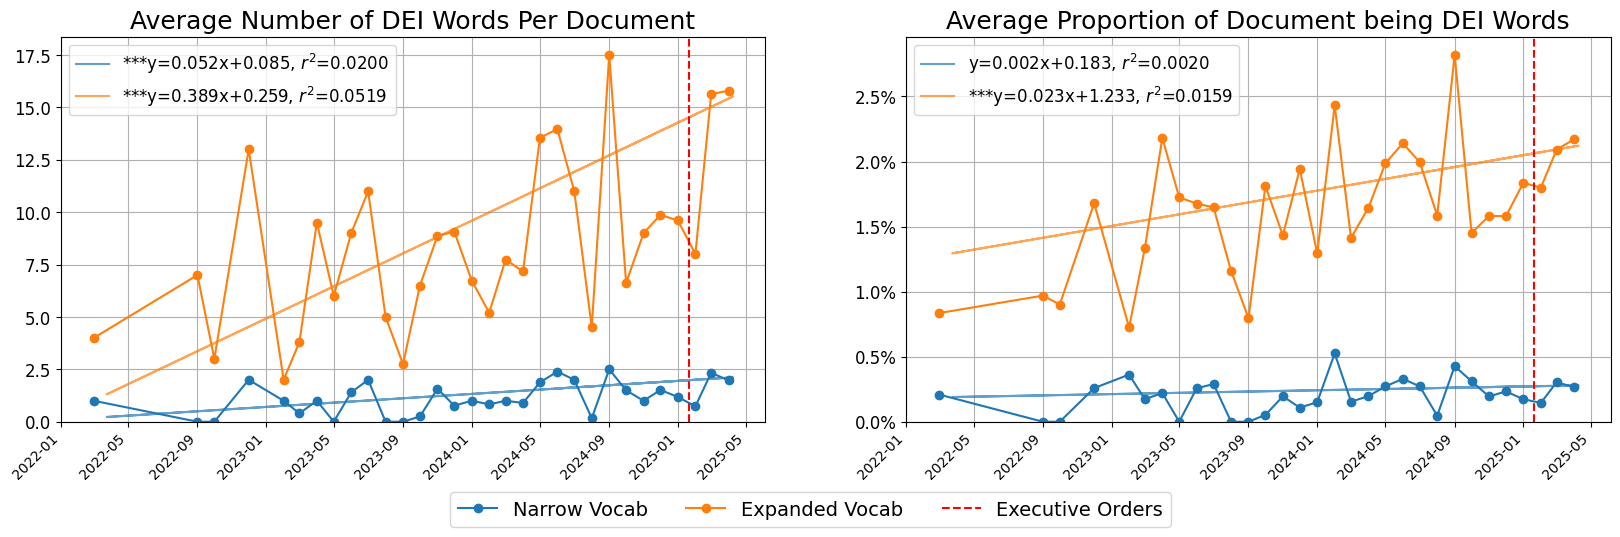

In [115]:
import matplotlib.dates as mdates
from collections import OrderedDict

# plot the two proportions together and the two counts together
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
metrics_pairs = [
    ('dei_narrow_count', 'dei_expanded_count'),
    ('dei_narrow_proportion', 'dei_expanded_proportion')
]

# set x range to start from january of earliest year
merged['date'] = pd.to_datetime(merged['job_posted_date'])
months = merged['date'].dt.to_period('M')
start_date = datetime(months.min().start_time.year, 1, 1)
start_day = mdates.date2num(start_date)

# choose a conversion from days -> months
# use average month length (365.2425/12 ≈ 30.436875 days)
days_per_month = 365.2425 / 12.0

global_handles = OrderedDict()
for i, (metric1, metric2) in enumerate(metrics_pairs):
    ax_i = ax[i]

    fit_lines = []
    for metric in [metric1, metric2]:
        if 'narrow' in metric:
            label = "Narrow Vocab"
            color = 'tab:blue'
        else:
            label = "Expanded Vocab"
            color = "tab:orange"
        merged[metric] = merged[metric].fillna(0)  # fill NaN proportions with 0
        monthly_means = merged.groupby(months)[metric].mean()
        monthly_means.index = monthly_means.index.to_timestamp()
        plot, = ax_i.plot(monthly_means.index, monthly_means.values, marker='o', color=color)
        global_handles[label] = plot
        # ax_i.scatter(merged['date'], merged[metric], color=color, alpha=0.1)

        # linear regression
        x_nums = mdates.date2num(merged['date'])   # floats (days since epoch)
        m, b, r_value, p_value, std_err = stats.linregress(x_nums, merged[metric])
        significance = ''
        for level in [0.05,0.01,0.001]:
            if p_value < level:
                significance += '*'
        print(f'Linear regression for {metric}: y={m:.6f}x + {b:.6f}, r^2={r_value**2:.4f}, p={p_value:.4f} {significance}, std_err={std_err:.6f}')
        # build fit line in numeric space, then convert back to dates for plotting
        y_fit = m*x_nums + b

        # also, for the label, show in terms of percents and months since start_date
        m_monthly = m * days_per_month
        b_start = m * start_day + b
        if 'proportion' in metric:
            m_monthly *= 100  # convert to percent
            b_start *= 100
        fit, = ax_i.plot(x_nums, y_fit, color=color, alpha = 0.7, label=f'{significance}y={m_monthly:.3f}x{"+" if b_start > 0 else ""}{b_start:.3f}, $r^2$={r_value**2:.4f}')
        fit_lines.append(fit)
    ax_i.legend(handles=fit_lines, loc='upper left', fontsize=12)


    ax_i.set_title(f'Average {"Number of DEI Words Per Document" if "count" in metric1 else "Proportion of Document being DEI Words"}', fontsize=18)
    # ax_i.set_xlabel('Date')
    ax_i.set_xlim(left=start_date) 
    plt.setp( ax_i.xaxis.get_majorticklabels(), rotation=45, ha="right" )

    ax_i.set_ylim(bottom=0)
    if 'proportion' in metric1: # convert decimal tick labels to percent
        ax_i.set_yticklabels([f"{t*100:.1f}%" for t in ax_i.get_yticks()])
    ax_i.tick_params(axis='y', labelsize=12)
    # ax_i.set_ylabel(f'Average {"# Occurrences" if "count" in metric1 else "Proportion of Words"}', fontsize=16)
    ax_i.grid()
    # ax_i.legend(fontsize=14)
    # add eo date line
    eo = ax_i.axvline(eo_datetime, color='red', linestyle='--')
    global_handles['Executive Orders'] = eo
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles=list(global_handles.values()),
           labels=list(global_handles.keys()), 
           ncol=len(global_handles), 
           loc='lower center', 
           bbox_to_anchor=(0.5, -0.12), 
           fontsize=14,)
plt.savefig('figures/word_counts.png', bbox_inches='tight')
plt.show()

## LLM processing
Annotating for holistic DEI sentiment.

In [126]:
merged = pd.read_csv('data/merged.csv')
print(merged.shape)

(1846, 13)


In [165]:
# do a validation sample of manual annotations
VAL_SIZE = 50
if 'manual_annotation' not in merged.columns:
    merged['manual_annotation'] = pd.Series(dtype=int)
    merged['manual_minimum_degree'] = pd.Series(dtype=str)
if merged['manual_annotation'].isnull().all():
    merged.loc[val_sample.index, 'manual_annotation'] = -1  # placeholder for manual annotation
    merged.to_csv('data/merged.csv', index=False)
val_sample = merged[merged['manual_annotation'].notna()]

In [166]:
val_sample.head()

,job_title,job_posted_date,company_name,job_description_text,num_applications,contract_type,seniority_level,work_type,sector,company_address_locality,company_address_region,company_website,company_description,manual_annotation,manual_minimum_degree
27,AI/ML Engineer,2024-04-30,Dwebtech Consulting Inc.,"Title: AI/ML Engineer\n\nLocation: Rutherford,...",134 applicants,Contract,Mid-Senior level,Engineering and Information Technology,Staffing and Recruiting,Rutherford,NJ,NaN,NaN,0.0,b
31,ARTIFICIAL INTELLIGENCE (AI)/MACHINE LEARNING ...,2024-05-22,"Infinite Management Solutions, LLC","Job Title: AI/ML Engineer\n\nLocation: Dayton,...",Be among the first 25 applicants,Full-time,Mid-Senior level,Engineering and Information Technology,Internet Publishing,Dayton,OH,NaN,NaN,1.0,b
52,Deep Learning Engineer,2024-04-29,"Matroid, Inc.",About Matroid\n\nWith the rapid growth of arti...,Be among the first 25 applicants,Full-time,Entry level,Engineering and Information Technology,Software Development,Palo Alto,CA,NaN,NaN,1.0,b
60,Data Scientist,2024-05-17,Ascendion,About Ascendion\n\nAscendion is a full-service...,Over 200 applicants,Full-time,Mid-Senior level,Information Technology and Engineering,Banking and Financial Services,Dallas,TX,NaN,NaN,1.0,b
61,Machine Learning Engineer,2024-05-25,HackerPulse,Showcase your software engineering talents usi...,Over 200 applicants,Full-time,Entry level,Engineering and Information Technology,Software Development,San Marino,CA,NaN,NaN,0.0,b


In [167]:

val_sample = merged[merged['manual_annotation'].notna()]
for i, row in val_sample.iterrows():
    if row['manual_annotation'] == -1:
        with open('temp', 'w') as f:
            f.write(f'Row {i}:\n\n'+row['job_description_text'])
        annotation = input(f"Please provide manual annotation for job posting {i} (0=non-DEI, 1=DEI (including EEO)):")
        merged.at[i, 'manual_annotation'] = int(annotation)
        degree = input(f"Please provide minimum degree required for job posting {i} (b=Bachelor's, m=Master's', p=PhD, e='equivalent experience', n=None):")
        merged.at[i, 'manual_minimum_degree'] = degree


In [168]:
merged.to_csv('data/merged.csv', index=False)
(merged['manual_annotation'].value_counts(), merged['manual_minimum_degree'].value_counts())

(manual_annotation
 0.0    26
 1.0    24
 Name: count, dtype: int64,
 manual_minimum_degree
 b    25
 n    18
 m     4
 e     3
 Name: count, dtype: int64)